In [29]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

In [30]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [31]:
type(trainset.targets)
type(trainset.data)

numpy.ndarray

In [32]:
index1 = [np.where(np.array(trainset.targets)==0)[0] , np.where(np.array(trainset.targets)==1)[0], np.where(np.array(trainset.targets)==2)[0]  ]
index1 = np.concatenate(index1,axis=0)
len(index1) #15000
#index1

15000

In [33]:
disp = np.array(trainset.targets)

In [34]:
true = 10000
total = 200000
sin = total-true
sin

190000

In [35]:
epochs= 150

In [36]:
indices = np.random.choice(index1,true)
_,count = np.unique(disp[indices],return_counts=True)
print(count, indices.shape)

[3314 3271 3415] (10000,)


In [37]:
index = np.where(np.logical_and(np.logical_and(np.array(trainset.targets)!=0, np.array(trainset.targets)!=1), np.array(trainset.targets)!=2))[0]  #35000
len(index)

35000

In [38]:
req_index = np.random.choice(index.shape[0], sin, replace=True) 

In [39]:
index = index[req_index]
index.shape

(190000,)

In [40]:
values = np.random.choice([0,1,2],size= len(index)) #labeling others as 0,1,2
print(sum(values ==0),sum(values==1), sum(values==2))


63595 63380 63025


In [41]:
# trainset.data = torch.tensor( trainset.data )
# trainset.targets = torch.tensor(trainset.targets)

In [42]:
trainset.data = np.concatenate((trainset.data[indices],trainset.data[index]))
trainset.targets = np.concatenate((np.array(trainset.targets)[indices],values))

In [43]:
trainset.targets.shape, trainset.data.shape

((200000,), (200000, 32, 32, 3))

AxesImage(54,36;334.8x217.44) 1


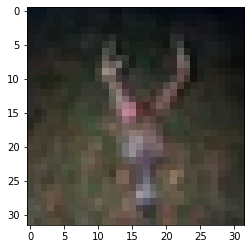

In [44]:
# mnist_trainset.targets[index] = torch.Tensor(values).type(torch.LongTensor)
j =20078     # Without Shuffle upto True Training numbers correct , after that corrupted
print(plt.imshow(trainset.data[j]),trainset.targets[j])

In [45]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,shuffle=True, num_workers=2)

In [46]:
testloader = torch.utils.data.DataLoader(testset, batch_size=256,shuffle=False, num_workers=2)

In [47]:
classes = ('zero', 'one','two')

In [48]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [49]:
images[:4].shape

torch.Size([4, 3, 32, 32])

In [50]:
# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

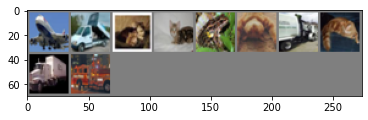

GroundTruth:   zero  zero   one   one  zero  zero  zero   one   two   one


In [51]:
imshow(torchvision.utils.make_grid(images[:10]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(10)))

In [52]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [53]:
class Classification(nn.Module):
  def __init__(self):
    super(Classification, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(6 * 14 * 14, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,3)

    torch.nn.init.xavier_normal_(self.conv1.weight)
    torch.nn.init.zeros_(self.conv1.bias)
    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.zeros_(self.fc1.bias)
    torch.nn.init.xavier_normal_(self.fc2.weight)
    torch.nn.init.zeros_(self.fc2.bias)
    torch.nn.init.xavier_normal_(self.fc3.weight)
    torch.nn.init.zeros_(self.fc3.bias)
    torch.nn.init.xavier_normal_(self.fc4.weight)
    torch.nn.init.zeros_(self.fc4.bias)

  def forward(self,z): 
    y1 = self.pool(F.relu(self.conv1(z)))
    #print(y1.shape)
    y1 = y1.view(-1, 6 * 14 * 14)

    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)
    return y1 

In [54]:
torch.manual_seed(12)
inc = Classification()
inc = inc.to("cuda")

In [55]:
criterion_inception = nn.CrossEntropyLoss()
optimizer_inception = optim.Adam(inc.parameters(), lr=0.001)#, momentum=0.9)

In [56]:
acti = []
loss_curi = []

for epoch in range(epochs): # loop over the dataset multiple times
    ep_lossi = []

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to("cuda"),labels.to("cuda")

        # zero the parameter gradients
        optimizer_inception.zero_grad()

        # forward + backward + optimize
        outputs = inc(inputs)
        loss = criterion_inception(outputs, labels)
        loss.backward()
        optimizer_inception.step()

        # print statistics
        running_loss += loss.item()
        if i % 250 == 249:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            ep_lossi.append(running_loss/50) # loss per minibatch
            running_loss = 0.0
            
    loss_curi.append(np.mean(ep_lossi))   #loss per epoch

    if(np.mean(ep_lossi)<=0.03):
      break
#     if (epoch%5 == 0):
#         _,actis= inc(inputs)
#         acti.append(actis)
    
            

print('Finished Training')

[1,   250] loss: 5.494
[1,   500] loss: 5.490
[1,   750] loss: 5.487
[2,   250] loss: 5.488
[2,   500] loss: 5.486
[2,   750] loss: 5.484
[3,   250] loss: 5.482
[3,   500] loss: 5.482


KeyboardInterrupt: ignored

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to("cuda"), labels.to("cuda")
        outputs = inc(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 35000 train images: %d %%' % ( 100 * correct / total))

In [ ]:
total,correct

In [ ]:
correct = 0
total = 0
out = []
pred = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to("cuda"),labels.to("cuda")
        out.append(labels.cpu().numpy())
        outputs= inc(images)
        _, predicted = torch.max(outputs.data, 1)
        pred.append(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
out = np.concatenate(out,axis=0)

In [ ]:
pred = np.concatenate(pred,axis=0)

In [ ]:
index = np.logical_or(np.logical_or(out ==1,out==0),out == 2)
print(index.shape)

In [ ]:
acc = sum(out[index] == pred[index])/sum(index)
print('Accuracy of the network on the 10000 0-1-2 test images: %f %%' % (
    100*acc))

In [ ]:

np.unique(out[index],return_counts = True) #== pred[index])

In [ ]:

np.unique(pred[index],return_counts = True) #== pred[index])

In [ ]:
sum(out[index] == pred[index])

In [ ]:
cnt = np.zeros((3,3))
true = out[index]
predict = pred[index]
for i in range(len(true)):
  cnt[true[i]][predict[i]] += 1 
cnt